In [1]:
import os
from dotenv import load_dotenv

def ensure_api_keys() -> tuple[str, str]:

    load_dotenv()

    required_vars = ["GOOGLE_API_KEY"]
    missing = []

    for var in required_vars:
        if not os.environ.get(var):
            missing.append(var)

    if missing:
        missing_list = ", ".join(missing)
        raise EnvironmentError(
            f"Missing required environment variables: {missing_list}. "
            "Set them in your OS environment or .env file."
        )

    return os.environ["GOOGLE_API_KEY"]


GOOGLE_API_KEY = ensure_api_keys()


In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.5-flash",
    temperature=0.2
)

In [4]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

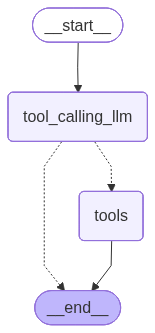

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (1f3315c4-5c91-41fc-8bb7-c69e800ea363)
 Call ID: 1f3315c4-5c91-41fc-8bb7-c69e800ea363
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


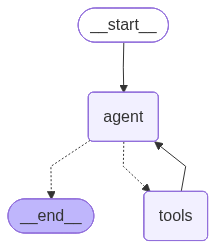


--- Test 1: 'What is 3.5 * 2.1?' ---
================================ Human Message =================================

What is 3.5 * 2.1?
================================== Ai Message ==================================
Tool Calls:
  multiply (0f6d5769-4751-4d24-92ef-8c03583f76fa)
 Call ID: 0f6d5769-4751-4d24-92ef-8c03583f76fa
  Args:
    a: 3.5
    b: 2.1
================================= Tool Message =================================
Name: multiply

7.3500000000000005
================================== Ai Message ==================================

3.5 * 2.1 = 7.35

--- Test 2: 'Hello, how are you?' ---
================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================

I'm doing well, thank you! I'm ready to help you with any math problems you have. For example, I can multiply two numbers for you. What would you like me to do?

--- Test 3: 'Calculate 10 * 0' ---


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 37.854556106s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

================================ Human Message =================================

Calculate 10 * 0
================================== Ai Message ==================================
Tool Calls:
  multiply (e01e4c94-bb19-40c9-9075-0e9675b37ba4)
 Call ID: e01e4c94-bb19-40c9-9075-0e9675b37ba4
  Args:
    a: 10
    b: 0
================================= Tool Message =================================
Name: multiply

0.0
================================== Ai Message ==================================

10 * 0 = 0

--- Test 4: 'What is the capital of France?' ---


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash
Please retry in 35.754067243s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 1

In [ ]:
import os

from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

if not GOOGLE_API_KEY:
    raise EnvironmentError("GOOGLE_API_KEY is not set")

from typing import Callable

from IPython.display import Image, display
from langchain_core.messages import AnyMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from typing_extensions import TypedDict


def multiply(a: float, b: float) -> float:

    """Multiply two floats.

    Args:
        a: first float
        b: second float
    """
    return a * b

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

class RouterAgent:
    def __init__(self,
                 Model_name: str="gemini-2.5-flash",
                 tools: list[Callable]=[multiply],
                 temperature: float=0.0):
        """Initialize router agent with LLM and tools."""
        self.builder = StateGraph(MessagesState)
        self.tools = tools
        self._setup_model(Model_name, temperature)
        self._setup_nodes()
        self._setup_edges()
        self.graph = self.builder.compile()


    def _setup_model(self, model_name: str, temperature: float):
        """Setup model"""
        self.llm = ChatGoogleGenerativeAI(
            google_api_key=GOOGLE_API_KEY,
            model=model_name,
            temperature=temperature
        )
        self.llm_with_tools = self.llm.bind_tools(self.tools)


    def _agent_node(self, state: MessagesState):
        """LLM decides: respond directly or call tool."""
        return {"messages": [self.llm_with_tools.invoke(state["messages"])]}

    def _setup_nodes(self):
        """Register all nodes"""
        self.builder.add_node("agent", self._agent_node)
        self.builder.add_node("tools", ToolNode(self.tools))

    def _setup_edges(self):
        """Register all edges"""
        self.builder.add_edge(START, "agent")
        self.builder.add_conditional_edges("agent", tools_condition)
        self.builder.add_edge("tools", "agent")
        self.builder.add_edge("agent", END)

    def invoke(self, messages: list[AnyMessage]):
        return self.graph.invoke({"messages": messages},
                                 )

    def stream(self, messages: list[AnyMessage]):
        return self.graph.stream({"messages": messages},
                                 )

    def show(self):
        """Display Mermaid diagram"""
        display(Image(self.graph.get_graph().draw_mermaid_png()))

graph = RouterAgent().graph


@traceable(name="RouterAgent")
def main():
        # Create agent
    agent = RouterAgent()

    # Show graph
    agent.show()


    # Test cases
    test_cases = [
        "What is 3.5 * 2.1?",
        "Hello, how are you?",
        "3*3*3"
    ]

    for i, query in enumerate(test_cases, 1):
        print(f"\n--- Test {i}: '{query}' ---")
        messages = [HumanMessage(content=query)]
        result = agent.invoke(messages)

        for msg in result["messages"]:
            msg.pretty_print()


if __name__ == "__main__":
    main()
